# **02장. 반도체 박막 두께 분석** 

2.1 문제 정의

2.2 탐색적 데이터 분석

2.3 데이터 전처리

2.4 모델 구축과 검증

2.5 성능 향상을 위한 방법

2.6 정리

# 2.1 문제 정의


2.1.1 경진대회 소개  [(대회 링크)](https://www.dacon.io/competitions/official/235554/overview/description/)

      : 반도체 공정 과정에서 박막의 결함으로 두께가 달라져 균일도가 저하되면 성능 문제 발생 
        -> 따라서, 박막의 두께 측정이 매우 중요 
        -> 딥러닝 기술로 박막의 반사율 스펙트럼 데이터를 분석해 반도체 소자의 두께 측정

2.1.2 평가척도

      : 4개의 박막층 두께를 예측하는 문제
        -> 예측한 4개 층의 두께와 실제 두께의 MAE(Mean Absolute Error, 평균절대오차)가 얼마나 작은지를 놓고 모델의 성능 판단 
        -> MAE 값이 작을수록 정답에 더 가까워짐
        (참고: 책 98쪽 MAE 계산 중 마지막 |0.013+0.013|에서 + 가 아닌 - 임)

2.1.3 문제 해결을 위한 접근 방식 ([추가 정보](https://www.dacon.io/competitions/official/235554/talkboard/400310?page=1&dtype=recent))
      
      : 박막의 두께를 예측하기 위해서는 '빛의 반사율' 사용
        -> 반사율 계산을 위해서는 입사각 및 편광 계산, 굴절률 계산 필요
        -> 모델에 대해서는 처음에는 랜덤 포레스트, XGBoost 이용 -> 다층 퍼셉트론 구성


2.1.4 분석환경 구축 (GPU, etc.)

# 2.2 탐색적 데이터 분석(EDA)

- EDA란?
  : 분석할 데이터의 구조, 변수의 타입 및 크기 등을 탐색하는 것

- 해당 경진대회에서는, 학습 데이터로 주어진 '반사율 스펙트럼값'에 대해 EDA 진행


2.2.1 데이터 분석 및 통계

- 연속형, 수치형 데이터

- **데이터 기초 통계** : [데이터 다운로드](https://www.dacon.io/competitions/official/235554/data/) (※주의※ 데이터가 1기가 이상 넘어감, 구글 드라이브에 압축 풀고, 마운트 쓰는 것 권장)

In [ ]:
import pandas as pd

#학습 및 테스트 데이터 불러오기
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data_mdc01/train.csv')
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data_mdc01/test.csv')

print("train shape is", train.shape) # (데이터 81만개, 박막 두께 정보 4개 + 226개의 반사율 스펙트럼)
print("test shape is", test.shape)

train shape is (810000, 230)
test shape is (10000, 227)


In [ ]:
# 학습데이터 살펴보기
train.head() # 박막의 두께는 10단위의 정수형, 반사율 스펙트럼값은 소수점 단위

,layer_1,layer_2,layer_3,layer_4,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,...,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225
0,10,10,10,10,0.254551,0.258823,0.254659,0.252085,0.247678,0.253614,0.246511,0.259407,0.260862,0.242524,0.253870,0.245156,0.245548,0.255501,0.228948,0.228632,0.225802,0.249418,0.246910,0.248747,0.251088,0.244886,0.233906,0.242632,0.221792,0.236521,0.220555,0.243761,0.230202,0.226122,0.220671,0.235075,0.224560,0.226998,0.209499,0.226594,...,0.160126,0.164192,0.171406,0.162364,0.168591,0.166626,0.169696,0.196383,0.194145,0.190646,0.186797,0.191748,0.190886,0.208518,0.211220,0.229286,0.226265,0.226954,0.229023,0.237112,0.262421,0.262566,0.272062,0.292049,0.305353,0.292889,0.317479,0.316911,0.321371,0.355636,0.354750,0.369223,0.388184,0.408496,0.414564,0.429403,0.419225,0.443250,0.433414,0.465502
1,10,10,10,20,0.205062,0.225544,0.217758,0.202169,0.199633,0.207380,0.191318,0.195369,0.200536,0.197588,0.198726,0.191803,0.199625,0.206465,0.182836,0.193341,0.180459,0.196416,0.185398,0.188913,0.176011,0.173457,0.182249,0.176816,0.192716,0.185924,0.183816,0.186900,0.161040,0.173525,0.172948,0.182634,0.161153,0.158073,0.152335,0.148293,...,0.327076,0.331195,0.337722,0.340189,0.342748,0.351925,0.372989,0.389663,0.396216,0.384977,0.383701,0.403894,0.406382,0.429342,0.409908,0.439307,0.432569,0.439114,0.459541,0.454988,0.475268,0.478575,0.483466,0.496912,0.499542,0.522705,0.524767,0.533952,0.558729,0.572470,0.557203,0.573656,0.587998,0.612754,0.627825,0.633393,0.637706,0.625981,0.653231,0.637853
2,10,10,10,30,0.189196,0.165869,0.177655,0.156822,0.175094,0.177755,0.157582,0.158885,0.156911,0.166162,0.148831,0.144950,0.151362,0.145110,0.159201,0.139296,0.145313,0.156555,0.145363,0.150352,0.150542,0.142990,0.139572,0.145669,0.144514,0.126263,0.112832,0.117535,0.111473,0.117545,0.107058,0.119299,0.110768,0.124217,0.124496,0.110023,...,0.525450,0.532645,0.539097,0.527091,0.531925,0.530325,0.551716,0.556125,0.567470,0.549711,0.566789,0.574313,0.569873,0.574390,0.601672,0.584206,0.602981,0.598708,0.615189,0.637023,0.626458,0.645439,0.629203,0.640967,0.652762,0.660495,0.676498,0.674599,0.693535,0.699182,0.699864,0.708688,0.721982,0.713464,0.743030,0.741709,0.747743,0.746037,0.737356,0.750391
3,10,10,10,40,0.131003,0.120076,0.138975,0.117931,0.130566,0.131262,0.126962,0.134453,0.106717,0.127309,0.099958,0.112908,0.106853,0.108288,0.101393,0.094074,0.086854,0.099669,0.107276,0.091117,0.084525,0.078293,0.076476,0.078559,0.072960,0.075898,0.067963,0.066055,0.087904,0.065373,0.075469,0.080097,0.068895,0.058148,0.057882,0.063258,...,0.616934,0.638654,0.630914,0.647135,0.629796,0.644114,0.641825,0.645360,0.653030,0.656335,0.657734,0.678019,0.676713,0.681540,0.673333,0.686743,0.697500,0.702650,0.693750,0.711013,0.714411,0.701010,0.726972,0.719394,0.726329,0.730821,0.740062,0.747356,0.749405,0.766173,0.764786,0.763788,0.770017,0.787571,0.778866,0.776969,0.774712,0.801526,0.805305,0.784057
4,10,10,10,50,0.091033,0.086893,0.108125,0.080405,0.105917,0.077083,0.097895,0.086765,0.078676,0.075729,0.086023,0.070649,0.078957,0.072772,0.069867,0.080523,0.068273,0.074660,0.069852,0.047442,0.067855,0.049580,0.068737,0.041386,0.048697,0.040278,0.050234,0.059371,0.042581,0.037117,0.041503,0.055113,0.034001,0.035846,0.030385,0.048935,...,0.670888,0.692846,0.673025,0.704448,0.696657,0.697524,0.692513,0.714224,0.696880,0.716361,0.723607,0.720018,0.715039,0.705079,0.720913,0.723440,0.719858,0.729948,0.731360,0.728861,0.740501,0.738362,0.749341,0.738456,0.768791,0.770292,0.766630,0.779970,0.787695,0.766521,0.786677,0.802271,0.806557,0.799614,0.789333,0.804087,0.787763,0.794948,0.819105,0.801781


In [ ]:
#자료형 살펴보기
train.info() #int64형 4개, float64형 226개 확인 완료!

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 810000 entries, 0 to 809999
Columns: 230 entries, layer_1 to 225
dtypes: float64(226), int64(4)
memory usage: 1.4 GB


In [ ]:
#기본적인 통계 살펴보기
train.loc[:,'0':'225'].describe() 
# 반사율 스펙트럼값 부분만 출력
# max값이 1을 넘지 않으므로 따로 정규화가 필요 없음을 확인!

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225
count,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,...,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000
mean,0.292653,0.292893,0.293125,0.293363,0.293666,0.293994,0.294344,0.294792,0.295325,0.295757,0.296188,0.296762,0.297396,0.298059,0.298745,0.299503,0.300220,0.301024,0.301834,0.302585,0.303395,0.304331,0.305255,0.306159,0.307080,0.307916,0.308737,0.309647,0.310584,0.311537,0.312403,0.313251,0.314086,0.314904,0.315711,0.316522,0.317295,0.318028,0.318752,0.319424,...,0.515799,0.516212,0.517059,0.518330,0.519609,0.520906,0.522183,0.523519,0.524838,0.526181,0.527548,0.528943,0.530954,0.533822,0.536751,0.539718,0.542706,0.545724,0.548767,0.551864,0.554950,0.558064,0.561231,0.565091,0.569481,0.574082,0.578907,0.583966,0.589218,0.594688,0.600336,0.606206,0.612238,0.618456,0.623942,0.625395,0.627100,0.628997,0.631166,0.633594
std,0.181642,0.181857,0.182055,0.182197,0.182361,0.182529,0.182693,0.182858,0.183057,0.183192,0.183337,0.183532,0.183731,0.183932,0.184135,0.184367,0.184559,0.184800,0.185021,0.185242,0.185466,0.185706,0.185972,0.186212,0.186465,0.186681,0.186877,0.187115,0.187331,0.187556,0.187732,0.187905,0.188082,0.188232,0.188361,0.188493,0.188607,0.188717,0.188786,0.188883,...,0.209915,0.209691,0.209475,0.209221,0.208968,0.208739,0.208539,0.208366,0.208186,0.208027,0.207935,0.207825,0.207651,0.207415,0.207167,0.206929,0.206699,0.206484,0.206228,0.205982,0.205727,0.205514,0.205216,0.204812,0.204335,0.203782,0.203131,0.202415,0.201604,0.200721,0.199727,0.198644,0.197473,0.196177,0.195028,0.194909,0.194730,0.194493,0.194146,0.193725
min,-0.014902,-0.014798,-0.014897,-0.014709,-0.014903,-0.014662,-0.014924,-0.014789,-0.014775,-0.014945,-0.014818,-0.014792,-0.014751,-0.014926,-0.014878,-0.014824,-0.014904,-0.014811,-0.014950,-0.014979,-0.014780,-0.014970,-0.014883,-0.015064,-0.014947,-0.014940,-0.014819,-0.014870,-0.014717,-0.014732,-0.014987,-0.014754,-0.014905,-0.014728,-0.014683,-0.014827,-0.015003,-0.014727,-0.014758,-0.014817,...,-0.014814,-0.015110,-0.014201,-0.014504,-0.014645,-0.014396,-0.014689,-0.014374,-0.014852,-0.014072,-0.014635,-0.014340,-0.014414,-0.014129,-0.013891,-0.014385,-0.014613,-0.013654,-0.014283,-0.014053,-0.014433,-0.013465,-0.010545,-0.014733,-0.014524,-0.014323,-0.013598,-0.012928,-0.012640,-0.012806,-0.011992,-0.008661,-0.011430,-0.009827,-0.007632,-0.007411,-0.007073,-0.007101,-0.005519,-0.006074
25%,0.135139,0.135180,0.135258,0.135478,0.135585,0.135705,0.135858,0.136423,0.136704,0.136993,0.137269,0.137756,0.138130,0.138556,0.139140,0.139715,0.140296,0.140825,0.141515,0.142154,0.142753,0.143431,0.144334,0.145081,0.145881,0.146606,0.147193,0.148069,0.148928,0.149679,0.150563,0.151352,0.152184,0.152947,0.153714,0.154655,0.

- 테스트 데이터도 위와 동일하게 확인해 보고, 큰 차이가 없다는 점 확인!

- **데이터 정보**  

  - train 에서 0 ~ 3 인덱스 => Y 데이터
  - train 에서 4 ~ -1 인덱스 => X 데이터
  - test 에서 0 인덱스 => id  (제출에 필요한듯)
  - test 에서 나머지 인덱스 => X 데이터

   => 즉, x 를 통해 y 를 맞추는 **회귀 문제** 

- **데이터 시각화** (우선 책에 있는 내용 따라해보고, 추가하기)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

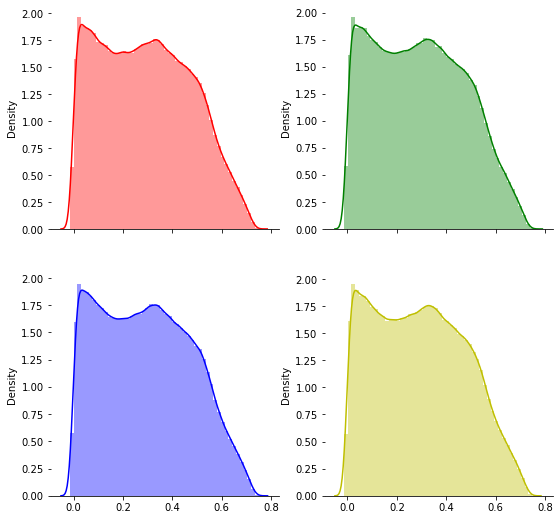

In [ ]:
import seaborn as sns 
import matplotlib.pyplot as plt

hist_0 = train.iloc[:,4:5]
hist_1 = train.iloc[:,5:6]
hist_2 = train.iloc[:,6:7]
hist_3 = train.iloc[:,7:8]

# 시각화를 위한 축과 크기를 설정합니다.
f, axes = plt.subplots(2, 2, figsize=(9,9), sharex=True)

# 보기 편하게 왼쪽 및 아래쪽 축을 제거합니다. 
sns.despine(left=True)

# 각각의 분포를 4개로 나누어 함께 찍어봅니다. 
sns.distplot(hist_0, kde=True, color="r", ax=axes[0, 0]) 
sns.distplot(hist_1, kde=True, color="g", ax=axes[0, 1])
sns.distplot(hist_2, kde=True, color="b", ax=axes[1, 0]) 
sns.distplot(hist_3, kde=True, color="y", ax=axes[1, 1]) 
plt.show()

# 2.3 데이터 전처리

- 제공된 데이터의 품질이 좋아서 전처리가 비교적 간단한 편

2.3.1 결측치 처리
      
      : 결측치는 제거하거나 채우는 방법으로 보완할 수 있음

In [ ]:
# 데이터의 행과 열에서 값이 존재하지 않는 경우를 찾아 그 수를 반환
null_check_train = train.isnull().sum() 
null_check_test = test.isnull().sum() 

print(null_check_train[null_check_train>0]) 
print(null_check_test[null_check_test>0])
#NULL값을 가진 결측치가 없는 것 확인!

Series([], dtype: int64)
Series([], dtype: int64)


2.3.2 데이터 파이프라인
    
    : 전처리 끝난 데이터를 가지고, 모델 학습 단계로 이어질 수 있게 파이프라인 구성 
      -> 검증 데이터셋 분리 (학습 데이터셋에서 약 13% 사용)
      -> 책에서는 따로 csv 를 저장해서 사용 
      -> 하지만 로컬환경이 아니기 때문에 파일 저장,업로드에 시간이 많이 소모되어 다른 방식 연구 필요

In [ ]:
#데이터 슬라이싱
y_data = train.iloc[:,:4]
y_data

,layer_1,layer_2,layer_3,layer_4
0,10,10,10,10
1,10,10,10,20
2,10,10,10,30
3,10,10,10,40
4,10,10,10,50
...,...,...,...,...
809995,300,300,300,260
809996,300,300,300,270
809997,300,300,300,280
809998,300,300,300,290


In [ ]:
x_data = train.iloc[:,4:]
x_data

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225
0,0.254551,0.258823,0.254659,0.252085,0.247678,0.253614,0.246511,0.259407,0.260862,0.242524,0.253870,0.245156,0.245548,0.255501,0.228948,0.228632,0.225802,0.249418,0.246910,0.248747,0.251088,0.244886,0.233906,0.242632,0.221792,0.236521,0.220555,0.243761,0.230202,0.226122,0.220671,0.235075,0.224560,0.226998,0.209499,0.226594,0.225476,0.224669,0.233551,0.224695,...,0.160126,0.164192,0.171406,0.162364,0.168591,0.166626,0.169696,0.196383,0.194145,0.190646,0.186797,0.191748,0.190886,0.208518,0.211220,0.229286,0.226265,0.226954,0.229023,0.237112,0.262421,0.262566,0.272062,0.292049,0.305353,0.292889,0.317479,0.316911,0.321371,0.355636,0.354750,0.369223,0.388184,0.408496,0.414564,0.429403,0.419225,0.443250,0.433414,0.465502
1,0.205062,0.225544,0.217758,0.202169,0.199633,0.207380,0.191318,0.195369,0.200536,0.197588,0.198726,0.191803,0.199625,0.206465,0.182836,0.193341,0.180459,0.196416,0.185398,0.188913,0.176011,0.173457,0.182249,0.176816,0.192716,0.185924,0.183816,0.186900,0.161040,0.173525,0.172948,0.182634,0.161153,0.158073,0.152335,0.148293,0.173913,0.164630,0.166498,0.149946,...,0.327076,0.331195,0.337722,0.340189,0.342748,0.351925,0.372989,0.389663,0.396216,0.384977,0.383701,0.403894,0.406382,0.429342,0.409908,0.439307,0.432569,0.439114,0.459541,0.454988,0.475268,0.478575,0.483466,0.496912,0.499542,0.522705,0.524767,0.533952,0.558729,0.572470,0.557203,0.573656,0.587998,0.612754,0.627825,0.633393,0.637706,0.625981,0.653231,0.637853
2,0.189196,0.165869,0.177655,0.156822,0.175094,0.177755,0.157582,0.158885,0.156911,0.166162,0.148831,0.144950,0.151362,0.145110,0.159201,0.139296,0.145313,0.156555,0.145363,0.150352,0.150542,0.142990,0.139572,0.145669,0.144514,0.126263,0.112832,0.117535,0.111473,0.117545,0.107058,0.119299,0.110768,0.124217,0.124496,0.110023,0.100011,0.107664,0.114942,0.098437,...,0.525450,0.532645,0.539097,0.527091,0.531925,0.530325,0.551716,0.556125,0.567470,0.549711,0.566789,0.574313,0.569873,0.574390,0.601672,0.584206,0.602981,0.598708,0.615189,0.637023,0.626458,0.645439,0.629203,0.640967,0.652762,0.660495,0.676498,0.674599,0.693535,0.699182,0.699864,0.708688,0.721982,0.713464,0.743030,0.741709,0.747743,0.746037,0.737356,0.750391
3,0.131003,0.120076,0.138975,0.117931,0.130566,0.131262,0.126962,0.134453,0.106717,0.127309,0.099958,0.112908,0.106853,0.108288,0.101393,0.094074,0.086854,0.099669,0.107276,0.091117,0.084525,0.078293,0.076476,0.078559,0.072960,0.075898,0.067963,0.066055,0.087904,0.065373,0.075469,0.080097,0.068895,0.058148,0.057882,0.063258,0.064540,0.057673,0.069113,0.066766,...,0.616934,0.638654,0.630914,0.647135,0.629796,0.644114,0.641825,0.645360,0.653030,0.656335,0.657734,0.678019,0.676713,0.681540,0.673333,0.686743,0.697500,0.702650,0.693750,0.711013,0.714411,0.701010,0.726972,0.719394,0.726329,0.730821,0.740062,0.747356,0.749405,0.766173,0.764786,0.763788,0.770017,0.787571,0.778866,0.776969,0.774712,0.801526,0.805305,0.784057
4,0.091033,0.086893,0.108125,0.080405,0.105917,0.077083,0.097895,0.086765,0.078676,0.075729,0.086023,0.070649,0.078957,0.072772,0.069867,0.080523,0.068273,0.074660,0.069852,0.047442,0.067855,0.049580,0.068737,0.041386,0.048697,0.040278,0.050234,0.059371,0.042581,0.037117,0.041503,0.055113,0.034001,0.035846,0.030385,0.048935,0.039065,0.036083,0.047991,0.036207,...,0.670888,0.692846,0.673025,0.704448,0.696657,0.697524,0.692513,0.714224,0.696880,0.716361,0.723607,0.720018,0.715039,0.705079,0.720913,0.723440,0.719858,0.729948,0.731360,0.728861,0.740501,0.738362,0.749341,0.738456,0.768791,0.770292,0.766630,0.779970,0.787695,0.766521,0.786677,0.802271,0.806557,0.799614,0.789333,0.804087,0.787763,0.794948,0.819105,0.801781
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [ ]:
from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test = train_test_split(x_data,y_data,test_size=0.25,random_state=777)
x_train

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225
254325,0.052627,0.035194,0.028972,0.007043,-0.001475,0.023814,0.052635,0.079363,0.125324,0.172455,0.210684,0.243851,0.305061,0.332463,0.384927,0.409284,0.429634,0.469525,0.486217,0.509923,0.546702,0.558540,0.569307,0.591854,0.600786,0.606806,0.626845,0.607103,0.615405,0.641714,0.642202,0.616299,0.621895,0.612569,0.605692,0.598987,0.608411,0.594372,0.574897,0.580910,...,0.331699,0.354765,0.407216,0.461964,0.493104,0.532760,0.593773,0.620776,0.659330,0.674134,0.722020,0.748024,0.764095,0.764681,0.782931,0.794830,0.805001,0.841346,0.845739,0.855550,0.847999,0.848725,0.843502,0.844668,0.867718,0.851285,0.846640,0.843540,0.852020,0.857909,0.834415,0.838264,0.825490,0.833475,0.812976,0.778480,0.771571,0.728813,0.680583,0.618299
514775,0.391012,0.404455,0.409479,0.407620,0.417042,0.435311,0.439143,0.427158,0.426437,0.439120,0.412685,0.421456,0.379318,0.368350,0.361493,0.348072,0.320674,0.300662,0.248357,0.233699,0.193324,0.172273,0.143599,0.111224,0.085949,0.077805,0.061014,0.069138,0.072114,0.094409,0.123612,0.147975,0.165169,0.200109,0.228683,0.265141,0.297888,0.351346,0.372259,0.414339,...,0.415775,0.326340,0.253137,0.194147,0.154586,0.139717,0.156063,0.201574,0.264972,0.373128,0.426689,0.511832,0.573889,0.601798,0.644587,0.678804,0.716502,0.744466,0.772079,0.785300,0.786615,0.800605,0.811828,0.816904,0.797680,0.797186,0.808589,0.801555,0.802065,0.805514,0.791022,0.764398,0.757055,0.748751,0.710812,0.703101,0.660804,0.612546,0.576918,0.559517
161203,0.458485,0.436831,0.409363,0.401397,0.362503,0.336020,0.324518,0.274629,0.264405,0.234726,0.202766,0.154660,0.138922,0.115701,0.072978,0.078908,0.041289,0.056136,0.049157,0.065763,0.060456,0.074291,0.106874,0.142545,0.190748,0.199986,0.253221,0.297078,0.317246,0.376819,0.381309,0.429456,0.449895,0.496364,0.514282,0.536369,0.552837,0.579964,0.592586,0.604623,...,0.410001,0.396199,0.377327,0.385380,0.377088,0.411123,0.413904,0.450607,0.481387,0.486342,0.524471,0.549452,0.577486,0.609862,0.652073,0.656017,0.693420,0.703016,0.722319,0.752260,0.763469,0.765988,0.776960,0.779138,0.805683,0.804878,0.828724,0.833834,0.831245,0.824947,0.831703,0.833302,0.843466,0.831253,0.857355,0.834699,0.855632,0.846493,0.850993,0.844473
338779,-0.010698,-0.003175,0.000944,0.008857,0.046239,0.075124,0.097095,0.116635,0.132693,0.162787,0.194931,0.228322,0.253966,0.270893,0.275778,0.301187,0.301602,0.317411,0.315201,0.326068,0.313385,0.328905,0.324365,0.317143,0.285569,0.286180,0.271444,0.251666,0.217149,0.205534,0.187132,0.159323,0.144386,0.102904,0.092771,0.072390,0.047901,0.034819,0.015937,0.026797,...,0.517585,0.530052,0.560308,0.580955,0.567448,0.587800,0.604124,0.580143,0.600876,0.585425,0.581348,0.565291,0.554859,0.549996,0.516415,0.480116,0.456589,0.446602,0.400644,0.386825,0.345420,0.324504,0.325820,0.321531,0.308536,0.336908,0.347033,0.375663,0.439800,0.480446,0.502393,0.553857,0.580736,0.623076,0.629895,0.660602,0.670754,0.682956,0.698233,0.722581
408306,0.307098,0.294857,0.258483,0.208321,0.180684,0.146045,0.130964,0.100894,0.080506,0.059902,0.020757,0.024182,0.006858,0.028003,0.026317,0.041180,0.048438,0.055641,0.083495,0.126142,0.148268,0.180039,0.200193,0.223237,0.263610,0.291556,0.291083,0.338757,0.332302,0.365163,0.385181,0.392834,0.418553,0.417191,0.424037,0.443845,0.449384,0.438078,0.439225,0.452642,...,0.591991,0.591842,0.576782,0.583902,0.585115,0.569649,0.569818,0.563377,0.527962,0.513406,0.488417,0.478768,0.442969,0.397112,0.347969,0.316915,0.259709,0.243384,0.191993,0.156889,0.136861,0.164875,0.186612,0.236541,0.288240,0.352113,0.413076,0.480148,0.552622,0.625727,0.655357,0.712724,0.721381,0.751219,0.773800,0.818788,0.832249,0.835877,0.857580,0.859250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

2.3.3 커스텀 데이터 클래스
   
    : 신경망의 경우, 데이터를 일정량만큼 묶어서 학습하므로 배치로 묶어주는 과정 필요
     -> 파이토치 사용(생략 가능하나, 공부하고 싶은 사람은 책 내용 기반으로 공부!)

# 2.4 모델 구축과 검증


2.4.1 모델 탐색

    : (1) 회귀 문제에 대한 머신러닝 모델 -> XGBoost(의사결정트리 기반의 앙상블 머신러닝 알고리즘)
      (2) 회귀 문제에 대한 신경망 모델 -> MLP (다층 퍼셉트론)


- 책에 있는 코드는 시간이 너무 오래 걸립니다. 모델링 예시 입니다.
- 다양한 방법으로 모델 구성 및 검증 해보는 것이 이번 챕터의 관건일 듯 합니다.
- 지난 스터디 때 익혔던 방식을 도입해도 좋습니다.

In [ ]:
# <랜덤 포레스트>
from sklearn.metrics import mean_absolute_error as mae
from sklearn.ensemble import RandomForestRegressor as RFR

rf = RFR(verbose=True)
rf.fit(x_train.iloc[:5000,:],y_train.iloc[:5000,:]) # 너무 오래걸려서 데이터 자름 ㅠㅠ 이러면 한 1분 나옴
y_pred = rf.predict(x_test.iloc[:2000,:])

print(f"RandomForest MAE Score: {mae(y_test.iloc[:2000,:],y_pred)}")

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


RandomForest MAE Score: 58.71539999999997


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished


In [ ]:
# <신경망 모델 (Kears)> 꼭 gpu 세션으로!!!
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
import numpy as np

np.random.seed(3)
tf.random.set_seed(3)

model = Sequential()
model.add(Dense(5000,input_dim=226,activation='relu')) # 입력층

model.add(Dense(3000,activation='relu')) # 은닉층
model.add(BatchNormalization())

model.add(Dense(1000,activation='relu')) # 은닉층
model.add(BatchNormalization())

model.add(Dense(500,activation='relu')) # 은닉층
model.add(BatchNormalization())

model.add(Dense(300,activation='relu')) # 은닉층
model.add(BatchNormalization())

model.add(Dense(4))# 출력층 ,출력 4개

#모델 컴파일, 학습
model.compile(loss='mean_absolute_error',optimizer='adam',metrics=['mae'])
early_stop = EarlyStopping(monitor='val_loss',patience=5,verbose=1)

model.fit(x_train,y_train,epochs=20,batch_size=1024,
          validation_split=0.2,callbacks=[early_stop])

model.evaluate(x_test,y_test)

Epoch 1/20
475/475 [==============================] - 41s 79ms/step - loss: 138.9195 - mae: 138.9195 - val_loss: 73.8004 - val_mae: 73.8004
Epoch 2/20
475/475 [==============================] - 37s 78ms/step - loss: 46.2670 - mae: 46.2670 - val_loss: 68.4732 - val_mae: 68.4732
Epoch 3/20
475/475 [==============================] - 37s 77ms/step - loss: 23.2996 - mae: 23.2996 - val_loss: 27.8437 - val_mae: 27.8437
Epoch 4/20
475/475 [==============================] - 37s 77ms/step - loss: 16.3882 - mae: 16.3882 - val_loss: 22.1900 - val_mae: 22.1900
Epoch 5/20
475/475 [==============================] - 37s 77ms/step - loss: 13.2827 - mae: 13.2827 - val_loss: 16.5333 - val_mae: 16.5333
Epoch 6/20
475/475 [==============================] - 36s 77ms/step - loss: 11.3550 - mae: 11.3550 - val_loss: 14.7973 - val_mae: 14.7973
Epoch 7/20
475/475 [==============================] - 36s 77ms/step - loss: 10.1389 - mae: 10.1389 - val_loss: 17.5613 - val_mae: 17.5613
Epoch 8/20
475/475 [============

[8.809783935546875, 8.809783935546875]

2.4.2 신경망 모델 구축

      : 머신러닝과 딥러닝은 '데이터 의존도, 특성 공학, 문제 접근 방법' 등에서 차이를 보인다.
       -> 해당 문제에서는 다층 퍼셉트론이 머신러닝 기법보다 더 좋은 결과를 얻을 수 있음
       -> 잔차 연결, 드롭아웃
    

2.4.3 모델 검증

    : (1) 잔차 연결 전후 비교 실험
      (2) 과적합 발생 여부 확인
      (3) 초기에 나눈 검증 데이터를 이용해 학습 상황 확인

# 2.5 성능 향상을 위한 방법

- 비교 연구 : 모델이나 알고리즘에 영향을 주는 요소를 하나씩 제거해가며, 그 요소가 성능에 얼마나 영향을 미치는지 확인해 보는 방법

2.5.1 정규화 기법 적용하기

    : 계층 정규화 층을 적용함으로써 더 좋은 효과 도출

2.5.2 추가 실험하기

    : 옵티마이저 및 스케줄러 조정, 하이퍼파라미터(배치 크기, 은닉층 노드 개수, 레이어 구성) 조정

2.5.3 앙상블

      : 다양한 종류의 모델을 결합해 개별 모델의 결과보다 더 우수한 성능을 얻는 것
       -> 대부분 경진대회의 높은 순위의 필수 조건
       -> 해당 문제에는 '보팅'기법 적용

# 2.6 정리

1. 데이콘 '코드 공유, 토론' 항목들을 살펴보면서 다른 사람은 어떻게 풀었나, 무슨 이슈들이 있었나 살펴 보는 것 추천 합니다.
(e.g. [읽어보기](https://www.dacon.io/competitions/official/235554/talkboard/400068?page=2&dtype=recent))

<hr>

2. 코드에서 그치지 말고, 왜 이 모델을 이렇게 사용하였나, 다른 파라미터를 바꾸면 어떻게 결과가 달라지나 등 여러 실험을 통하여 확인 후에 다양한 경험들을 정리하여 발표를 하는 방향이 좋을 것 같습니다.

<hr>

3. 각 팀의 준비 역량에 따라 '베이스라인 코드만 짜기' 부터 ~ '심화 내용' 까지 다룰 수 있을 것으로 기대됩니다.

<hr> 

4. 신경망(파이토치) 부분은 실습은 진행 안해도 괜찮으나, 내용은 한번 읽어볼 필요는 있을 것 같아요. 능력이 되면 파이토치 말고 케라스로 한번 옮겨보는 것도 좋을 것 같습니다.

<hr> 

5. 마지막으로 데이콘에 "제출" 까지 해 봅시다!